**Juan Esteban Floyd y Juan David Aycardi**

# Guía de trabajo redes neuronales.

Para esta actividad deben construir una red neuronal como las vistas en clase (no se aceptan otros tipos de redes como las convolucionales o recurrentes). Para esta red neuronal deben realizar una búsqueda de hiperparámetros de tal forma que se maximice el rendimiento del modelo en el conjunto de prueba. Para la búsqueda de hiperparámetros, se recomienda usar la búsqueda aleatoria.

## Etapa 1: Carga de los datos.

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para esta actividad, usaremos la base de datos Fashion-MNIST, la cual consiste en identificar tipos de prendas de vestir https://keras.io/api/datasets/fashion_mnist/. Esta base de datos configura un problema de 10 clases.

Se cargan las librerías necesarias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report

Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape)

(60000, 28, 28)


Las imágenes tienen tamaño 28x28. A continuación de muestran algunos ejemplos.


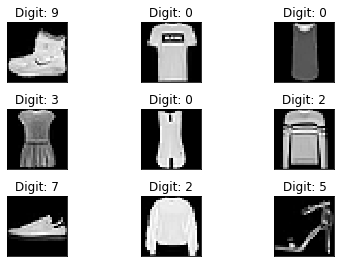

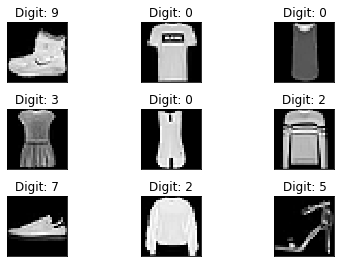

In [4]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
d1, d2, d3 = x_train.shape
x_train_flat = x_train.reshape((d1, d2*d3))/255
d1, d2, d3 = x_test.shape
x_test_flat = x_test.reshape((d1, d2*d3))/255

In [6]:
model = Sequential()
# Se define el tamaño de la entrada en 784, que corresponde con la dimensión de los 
# datos. La primera capa tiene 1024 unidades con activación ReLU.
model.add(Dense(1024, input_shape=(784,), activation='relu')) 
# La segunda capa presenta 512 unidades con activación ReLU.
model.add(Dense(512, activation='relu'))
# La tercera capa, corresponde a la capa de salida. Como es un problema de clasificación
# de múltiples clases, la capa de salida debe tener tantas unidades como clases.
# Además, debe usarse la activación softmax. 
model.add(Dense(10, activation='softmax'))

In [7]:
# Con model.summary() podemos verificar las capas que definimos y la cantidad de 
# parámetros en cada capa.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________


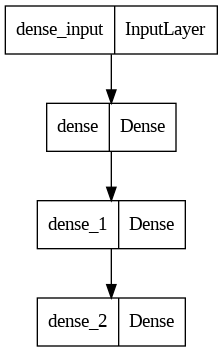

In [8]:
plot_model(model)

In [9]:
# Se compila el modelo. En este punto se define, la función de costo, el optimizador y
# la métrica usada para medir el rendimiento.
# 1. Para el loss se usa el sparse_categorical_crossentropy dado que es un problema de 
# clasificación multi-clase.
# 2. Utilizamos el optimizador sgd, el cual es un algoritmo basado en gradiente.
# 3. Finalmente, se usa el accuracy para medir el rendimiento.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.04)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [10]:
# Ahora, es momento de entrenar la red neuronal, lo cual corresponde a calcular 
# parámetros de la red. 
# 1. Se pasan los datos de entrenamiento x_train y y_train.
# 2. El número de épocas, en este caso, obedece a la cantidad de repeticiones 
#    del entrenamiento.
# 3. El batch_size, será un parámetro que discutiremos en la siguiente unidad, 
#    por ahora lo fijamos para que sea igual a la cantidad de muestras en el 
#.   conjunto de entrenamiento. 
model.fit(x_train_flat, y_train, epochs=150, batch_size=60000, validation_data= (x_test_flat, y_test))

Epoch 1/150
1/1 [==============================] - 9s 9s/step - loss: 2.3359 - accuracy: 0.0994 - val_loss: 2.1936 - val_accuracy: 0.1743
Epoch 2/150
1/1 [==============================] - 0s 261ms/step - loss: 2.1916 - accuracy: 0.1746 - val_loss: 2.0907 - val_accuracy: 0.3164
Epoch 3/150
1/1 [==============================] - 0s 219ms/step - loss: 2.0878 - accuracy: 0.3237 - val_loss: 2.0007 - val_accuracy: 0.4657
Epoch 4/150
1/1 [==============================] - 0s 204ms/step - loss: 1.9971 - accuracy: 0.4773 - val_loss: 1.9182 - val_accuracy: 0.5478
Epoch 5/150
1/1 [==============================] - 0s 217ms/step - loss: 1.9139 - accuracy: 0.5539 - val_loss: 1.8421 - val_accuracy: 0.5842
Epoch 6/150
1/1 [==============================] - 0s 218ms/step - loss: 1.8372 - accuracy: 0.5926 - val_loss: 1.7717 - val_accuracy: 0.6053
Epoch 7/150
1/1 [==============================] - 0s 209ms/step - loss: 1.7662 - accuracy: 0.6130 - val_loss: 1.7062 - val_accuracy: 0.6169
Epoch 8/150
1/1 

In [11]:
test_loss, test_acc = model.evaluate(x_test_flat, y_test)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.6641 - accuracy: 0.7726
test_acc: 0.772599995136261


# Búsqueda de hiperparámetros con Grid Search y Random Search

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
def build_model(optimizer, activation, node):
  model = Sequential()
  model.add(Dense(node * 2, input_shape=(784,), activation=activation))
  model.add(Dense(node, activation=activation))
  model.add(Dense(10, activation='softmax'))
  if optimizer == 'rmsprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.04)
  elif optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.04)
  elif optimizer == 'adagrad':
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.04)
  elif optimizer == 'adadelta':
    tf.keras.optimizers.Adadelta(learning_rate=0.04)
  else:
    tf.keras.optimizers.SGD(learning_rate=0.04)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn = build_model)
optimizers = ['rmsprop', 'adam', 'adagrad', 'adadelta', 'SGD']
epochs = np.array([150, 200])
nodes = np.array([64,128,256,512])
activations = ['relu', 'sigmoid', 'tanh']
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, activation=activations, node=nodes)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring = "accuracy")
grid_result = grid.fit(x_train_flat, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#Stochastic Gradient Descent (SGD): It is a widely used optimizer that updates the model parameters in the direction of the negative gradient of the loss function.

#Adam: It is a popular optimizer that uses a combination of adaptive learning rates and momentum to update the model parameters. It is particularly useful for large datasets and deep learning models.

#Adagrad: It is an optimizer that adapts the learning rate for each parameter based on the historical gradients. It performs well for sparse data.

#Adadelta: It is an extension of Adagrad that adapts the learning rate based on a moving window of gradient updates instead of accumulating all past gradients.

#RMSprop: It is an optimizer that divides the learning rate by a moving average of the root mean squared gradients.


<ipython-input-12-992d2b17cf6b>:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_model)


1875/1875 [==============================] - 5s 2ms/step - loss: 0.4999 - accuracy: 0.8168
Best: 0.849983 using {'optimizer': 'adagrad', 'node': 256, 'nb_epoch': 200, 'activation': 'relu'}
